## Setup

In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from collections import defaultdict
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras import layers

## Dataset

For this example we will be using the
[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.

In [10]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype("float32") / 255.0

y_train = np.squeeze(y_train)
x_test = x_test.astype("float32") / 255.0
y_test = np.squeeze(y_test)
x_train.shape
#print(y_test)

(50000, 32, 32, 3)

To get a sense of the dataset, we can visualise a grid of 25 random examples.


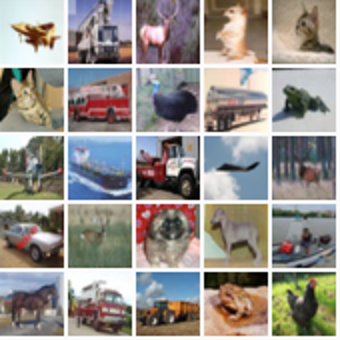

In [20]:
height_width = 32


def show_collage(examples):
    box_size = height_width + 2
    num_rows, num_cols = examples.shape[:2]

    collage = Image.new(
        mode="RGB",
        size=(num_cols * box_size, num_rows * box_size),
        color=(250, 250, 250),
    )
    for row_idx in range(num_rows):
        for col_idx in range(num_cols):
            array = (np.array(examples[row_idx, col_idx]) * 255).astype(np.uint8)
            collage.paste(
                Image.fromarray(array), (col_idx * box_size, row_idx * box_size)
            )

    
    collage = collage.resize((2 * num_cols * box_size, 2 * num_rows * box_size))
    return collage



sample_idxs = np.random.randint(0, 50000, size=(5, 5))
examples = x_train[sample_idxs]
show_collage(examples)

In [23]:
class_idx_to_train_idxs = defaultdict(list)
for y_train_idx, y in enumerate(y_train):
    class_idx_to_train_idxs[y].append(y_train_idx)

class_idx_to_test_idxs = defaultdict(list)
for y_test_idx, y in enumerate(y_test):
    class_idx_to_test_idxs[y].append(y_test_idx)

Passing Anchor, Positive and Negative triplet as an input to the model.

In [24]:
num_classes = 10


class AnchorPositivePairs(keras.utils.Sequence):
    def __init__(self, num_batchs):
        self.num_batchs = num_batchs

    def __len__(self):
        return self.num_batchs

    def __getitem__(self, _idx):
        x = np.empty((3, num_classes, height_width, height_width, 3), dtype=np.float32)
        for class_idx in range(num_classes):
            examples_for_class = class_idx_to_train_idxs[class_idx]
            anchor_idx = random.choice(examples_for_class)
            positive_idx = random.choice(examples_for_class)
            while positive_idx == anchor_idx:
                positive_idx = random.choice(examples_for_class)
            

            # for negative class samples
            negative_class_idx=random.choice([i for i in range(num_classes)])
            while negative_class_idx == class_idx:
              negative_class_idx=random.choice([i for i in range(num_classes)])

            examples_for_negative_class = class_idx_to_train_idxs[negative_class_idx]

            negative_idx = random.choice(examples_for_negative_class)


            x[0, class_idx] = x_train[anchor_idx]
            x[1, class_idx] = x_train[positive_idx]
            x[2, class_idx] = x_train[negative_idx]

        return x


We can visualise a batch in another collage. The top row shows randomly chosen anchors
from the 10 classes, the next two rows shows the corresponding positives and negative images of that anchor image respectively.

(3, 10, 32, 32, 3)


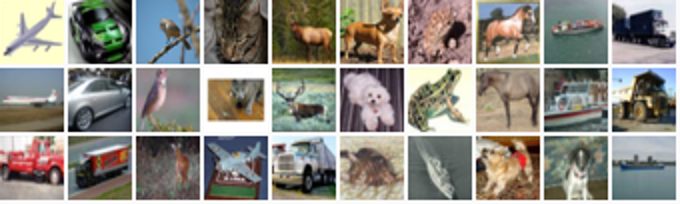

In [26]:
examples = next(iter(AnchorPositivePairs(num_batchs=1)))
show_collage(examples)

In [7]:
class DistanceLayer(layers.Layer):

    def call(self, anchor, positives, negatives):
      ap_distance=tf.reduce_sum(tf.square(anchor - positives), -1)
      an_distance=tf.reduce_sum(tf.square(anchor - negatives), -1)
      return(ap_distance, an_distance) 

## Embedding model

We define a custom model with a `train_step` that first embeds both anchors and positives
and then uses their pairwise dot products as logits for a softmax.

In [27]:

class EmbeddingModel(keras.Model):
    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        anchor, positives, negatives = data[0], data[1], data[2]
        # print(tf.GradientTape())
        with tf.GradientTape() as tape:
           
            anchor_embeddings = self(anchor, training=True)
            positive_embeddings = self(positives, training=True)
            negative_embeddings = self(negatives, training=True)

            
            similarities = tf.einsum(
                "ae,pe->ap", anchor_embeddings, positive_embeddings
            )
        
            temperature = 0.2
            similarities /= temperature

            sparse_labels = tf.range(num_classes)
            loss = self.compiled_loss(sparse_labels, similarities)

            ap, an = DistanceLayer()(anchor_embeddings, positive_embeddings, negative_embeddings)
            loss_2=ap - an
            loss_2=tf.maximum(loss_2+0.5, 0.0)

            loss_actual = loss + loss_2

        # Calculate gradients and apply via optimizer.
        gradients = tape.gradient(loss_actual, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # Update and return metrics (specifically the one for the loss value).
        self.compiled_metrics.update_state(sparse_labels, similarities)
        return {m.name: m.result() for m in self.metrics}


In [28]:
inputs = layers.Input(shape=(height_width, height_width, 3))
x = layers.Conv2D(filters=32, kernel_size=3, strides=2, activation="relu")(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, strides=2, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, strides=2, activation="relu")(x)
x = layers.GlobalAveragePooling2D()(x)
embeddings = layers.Dense(units=8, activation=None)(x)
embeddings = tf.nn.l2_normalize(embeddings, axis=-1)

model = EmbeddingModel(inputs, embeddings)

Next we describe the architecture that maps from an image to an embedding. This model
simply consists of a sequence of 2d convolutions followed by global pooling with a final
linear projection to an embedding space. As is common in metric learning we normalise the
embeddings so that we can use simple dot products to measure similarity. For simplicity
this model is intentionally small.

Finally we run the training. On a Google Colab GPU instance this takes about a minute.

In [10]:
model.summary()

Model: "embedding_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 15, 15, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 global_average_pooling2d (G  (None, 128)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 8)                 1032      
                                                   

Epoch 1/120
2000/2000 [==============================] - 53s 26ms/step - loss: 2.1508
Epoch 2/120
2000/2000 [==============================] - 44s 22ms/step - loss: 2.0168
Epoch 3/120
2000/2000 [==============================] - 43s 21ms/step - loss: 1.9450
Epoch 4/120
2000/2000 [==============================] - 43s 22ms/step - loss: 1.8907
Epoch 5/120
2000/2000 [==============================] - 40s 20ms/step - loss: 1.8204
Epoch 6/120
2000/2000 [==============================] - 42s 21ms/step - loss: 1.7609
Epoch 7/120
2000/2000 [==============================] - 44s 22ms/step - loss: 1.7281
Epoch 8/120
2000/2000 [==============================] - 38s 19ms/step - loss: 1.6959
Epoch 9/120
2000/2000 [==============================] - 40s 20ms/step - loss: 1.6543
Epoch 10/120
2000/2000 [==============================] - 42s 21ms/step - loss: 1.6278
Epoch 11/120
2000/2000 [==============================] - 45s 22ms/step - loss: 1.5955
Epoch 12/120
2000/2000 [============================

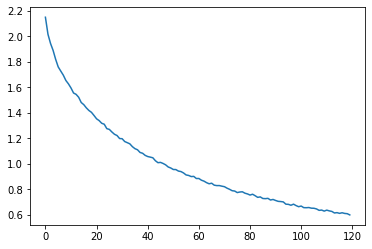

In [11]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
)

history = model.fit(AnchorPositivePairs(num_batchs=2000), epochs=120)

plt.plot(history.history["loss"])
plt.show()

## Testing

We can review the quality of this model by applying it to the test set and considering
near neighbours in the embedding space.

First we embed the test set and calculate all near neighbours. Recall that since the
embeddings are unit length we can calculate cosine similarity via dot products.

In [ ]:
near_neighbours_per_example = 10

embeddings = model.predict(x_test)
gram_matrix = np.einsum("ae,be->ab", embeddings, embeddings)
near_neighbours = np.argsort(gram_matrix.T)[:, -(near_neighbours_per_example + 1) :]

As a visual check of these embeddings we can build a collage of the near neighbours for 5
random examples. The first column of the image below is a randomly selected image, the
following 10 columns show the nearest neighbours in order of similarity.

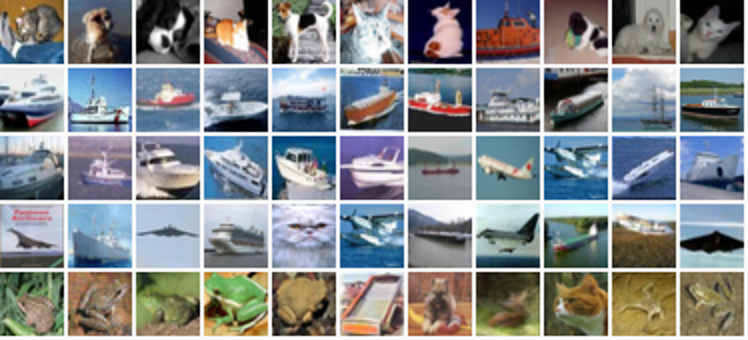

In [13]:
num_collage_examples = 5

examples = np.empty(
    (
        num_collage_examples,
        near_neighbours_per_example + 1,
        height_width,
        height_width,
        3,
    ),
    dtype=np.float32,
)
for row_idx in range(num_collage_examples):
    examples[row_idx, 0] = x_test[row_idx]
    anchor_near_neighbours = reversed(near_neighbours[row_idx][:-1])
    for col_idx, nn_idx in enumerate(anchor_near_neighbours):
        examples[row_idx, col_idx + 1] = x_test[nn_idx]

show_collage(examples)

We can also get a quantified view of the performance by considering the correctness of
near neighbours in terms of a confusion matrix.

Let us sample 10 examples from each of the 10 classes and consider their near neighbours
as a form of prediction; that is, does the example and its near neighbours share the same
class?

We observe that each animal class does generally well, and is confused the most with the
other animal classes. The vehicle classes follow the same pattern.

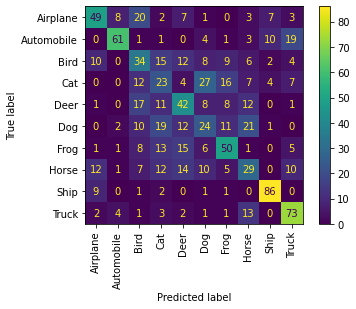

In [14]:
confusion_matrix = np.zeros((num_classes, num_classes))

# For each class.
for class_idx in range(num_classes):
    # Consider 10 examples.
    example_idxs = class_idx_to_test_idxs[class_idx][:10]
    for y_test_idx in example_idxs:
        # And count the classes of its near neighbours.
        for nn_idx in near_neighbours[y_test_idx][:-1]:
            nn_class_idx = y_test[nn_idx]
            confusion_matrix[class_idx, nn_class_idx] += 1

# Display a confusion matrix.
labels = [
    "Airplane",
    "Automobile",
    "Bird",
    "Cat",
    "Deer",
    "Dog",
    "Frog",
    "Horse",
    "Ship",
    "Truck",
]
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)
disp.plot(include_values=True, cmap="viridis", ax=None, xticks_rotation="vertical")
plt.show()